# Deep Learning
## HW4 - Problem 1 

1.   Full Name: Ehsanollah Shourezari
2.   Student Number: 400206295

The code origin : https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-seq2seq-model

In [1]:
from google.colab import drive
from google.colab import files
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# you can comment this cell when you run it
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data download

# if you got rror in running this cell uncomment the next line 
!pip install --upgrade --no-cache-dir gdown

!mkdir data 
%cd /content/data/
!gdown 133cM1NJWJuys6SKHv_XaAHtbTY91wtgY
%cd /content

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/content/data
Downloading...
From: https://drive.google.com/uc?id=133cM1NJWJuys6SKHv_XaAHtbTY91wtgY
To: /content/data/ferdousi.txt
100% 4.54M/4.54M [00:00<00:00, 236MB/s]
/content


In [4]:
# encoding all the words to one-hot (index) vectors
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# remove extra spaces, trim punctuations

def normalizeString(s):
    s = unicodeToAscii(s.strip())
    s = re.sub(r"([؟!.،؛])", r"", s)

    return s

In [6]:
# spliting data to input and output
def readLangs(lang1, lang2):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/data/ferdousi.txt' , encoding='utf-8').read().strip().split('\n')
    
    # Split every 2-line into pairs and normalize (Mesra instead of Beyt)

    pair = []
    pairs = []
    
    j = 0
    for i in lines[2:] :  
        pair.append(normalizeString(i))     
        if j%2 : 
          pairs.append(pair)
          pair = []
        j = j + 1  
  
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
# find the maximum num of words in a Mesra (for probable purposes like padding , ... )

def MaxNumWord() :
    
    lines = open('/content/data/ferdousi.txt' , encoding='utf-8').read().strip().split('\n')
    lenWord = [len(Mesra.split(' ')) for Mesra in lines[2:] ]
    maxWord = max(lenWord)


    return maxWord
    

In [8]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s Beyt pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('Mesra_1', 'Mesra_2')
a = random.choice(pairs)
print(a)
print(a[0])
print(a[1])

Reading lines...
Read 49608 Beyt pairs
Counting words...
Counted words:
Mesra_1 12463
Mesra_2 13078
['که با من چه کرد اندران گستهم', 'غم و شادمانیش با من بهم']
که با من چه کرد اندران گستهم
غم و شادمانیش با من بهم


## Seq2Seq model

In [9]:
# encoder network
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, arch):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.arch = arch.lower()
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        if arch.lower() == 'lstm' :
           self.myRNN = nn.LSTM(hidden_size, hidden_size)
        elif arch.lower() == 'gru' : 
           self.myRNN = nn.GRU(hidden_size, hidden_size, bidirectional = True)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.myRNN(output, hidden)

        return output, hidden

    def initHidden(self):
        if self.arch == 'lstm' :
           return (torch.zeros(1, 1, self.hidden_size, device=device),torch.zeros(1, 1, self.hidden_size, device=device))
        elif self.arch == 'gru' : 
           return torch.zeros(2, 1, self.hidden_size, device=device)

In [10]:
# decoder_network
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, arch):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.arch = arch.lower()
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        if arch.lower() == 'lstm' :
           self.myRNN = nn.LSTM(hidden_size, hidden_size)
        elif arch.lower() == 'gru' : 
           self.myRNN = nn.GRU(hidden_size, hidden_size, bidirectional = True)
        
        if arch.lower() == 'lstm' :
           self.out = nn.Linear(hidden_size, output_size)
        elif arch.lower() == 'gru' : 
          self.out = nn.Linear(2*hidden_size, output_size)

        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        output, hidden = self.myRNN(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
# Preparing Data for RNN network

# To train, for each pair we will need an input tensor (indexes of the
# words in the input sentence) and target tensor (indexes of the words in
# the target sentence). While creating these vectors we will append the
# EOS token to both sequences.


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [12]:
# sample wise training

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)



    loss = 0

    for ei in range(input_length):  
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden



    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
              decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing



    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [13]:
# training process:

# -  Initialize optimizers and criterion
# -  Create set of training pairs
# -  Start empty losses array for plotting

# Then we call ``train`` many times and occasionally print the progress (%
# of examples, time so far, estimated time) and average loss.


def train_loop(data , model, loss_fn , optimizer):

    encoder = model[0]
    decoder = model[1]

    encoder_optimizer = optimizer[0]
    decoder_optimizer = optimizer[1]

    loss_hist = []
    loss_total = 0
    size = len(data)
    
    training_pairs = copy.copy(data)
    random.shuffle(training_pairs)
    training_pairs = [tensorsFromPair(training_pairs[i])
                      for i in range(size)]
    criterion = loss_fn

    for i in range(len(training_pairs)):
        training_pair = training_pairs[i]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
        loss_total += loss

        logger_dis = 6000
        if i % logger_dis == 0:
            loss_avg = loss_total / logger_dis
            loss_hist.append(loss_avg)
            loss_total = 0
            current = i

            print(f"loss: {loss_avg:>7f}  [{current:>5d}/{size:>5d}]")

    return loss_hist


In [14]:
# evaluation process :

def eval_loop(data, data_name, model, loss_fn) :

    encoder = model[0]
    decoder = model[1]

    size = len(data)
    eval_loss, eval_acc = 0, 0

    with torch.no_grad():
        for i in range(size):
            training_pair = tensorsFromPair(data[i])

            loss , correct = LossAcc(training_pair , encoder, decoder, loss_fn)
            eval_loss += loss
            eval_acc += correct

    
    eval_loss /= size
    eval_acc /= size
    print(f"{data_name} : \n Accuracy: {(100*eval_acc):>0.1f}%, Avg loss per Mesra: {eval_loss:>8f} \n")
    return eval_acc , eval_loss


   
def LossAcc(pairs , encoder, decoder, loss_fn, max_length = MaxNumWord()):
   
    with torch.no_grad():

        input_tensor = pairs[0]
        target_tensor = pairs[1]


        input_length = input_tensor.size()[0]
        target_length = target_tensor.size()[0]
        encoder_hidden = encoder.initHidden()


        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        dec_out = []
        loss = 0
        correct = 0

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += loss_fn(decoder_output, target_tensor[di])
            topv, topi = decoder_output.topk(1)
            
            
            correct += (topi.item() == target_tensor[di]).type(torch.float).item()
             
            if topi.item() == EOS_token or target_tensor[di] == EOS_token :
                break
            
            decoder_input = topi.squeeze().detach()

        return loss.item() / target_length , correct / target_length

In [15]:
# epoch-wise training function

def train_epochs(data , model, loss_fn , optimizer, epoch , best_model_path) :

    Acc_tr_hist  = []
    loss_tr_hist = []
    Acc_te_hist  = []
    loss_te_hist = []

    train_data = data[0]
    test_data = data[1] 


    for t in range(epoch):
        model[0].train()
        model[1].train()
        print(f"Epoch {t+1}\n-------------------------------")

        train_loop(train_data , model, loss_fn , optimizer) 
        acc_tr , loss_tr = eval_loop(train_data,'train', model,loss_fn) 

        Acc_tr_hist.append(acc_tr)
        loss_tr_hist.append(loss_tr)
      

        model[0].eval()
        model[1].eval()

        acc_te,loss_te = eval_loop(test_data,'test', model,loss_fn)

        Acc_te_hist.append(acc_te)
        loss_te_hist.append(loss_te)
    
        if max(Acc_te_hist) == acc_te or max(Acc_tr_hist) == acc_tr :
           torch.save(model[0].state_dict() , best_model_path[0]  )  
           torch.save(model[1].state_dict() , best_model_path[1]  )  
           epoch_BestModel = t+1
    print("Job is Done!")
    print(f"the best trained model accuracy in test data: {Acc_te_hist[epoch_BestModel-1]}" )
    return Acc_tr_hist ,loss_tr_hist ,Acc_te_hist ,loss_te_hist
     
    

In [16]:
# vsualizing model loss and accuracy across the epochs
import matplotlib.pyplot as plt

def MyModelAnalysis(arch_name , Acc_tr_hist , Acc_te_hist , loss_tr_hist , loss_te_hist, epochs) :
   
    
    fig, ax = plt.subplots()
    ax.plot(np.arange(epochs)+1,Acc_tr_hist, c='c', label='training Accuracy')
    ax.plot(np.arange(epochs)+1,Acc_te_hist, c='m', label='test Accuracy')
    plt.legend(loc='upper left')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy for {arch_name} arcitechture")
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.arange(epochs)+1,loss_tr_hist, c='c', label='training loss')
    ax.plot(np.arange(epochs)+1,loss_te_hist, c='m', label='test loss')
    plt.legend(loc='upper left')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(f"loss changes in {arch_name} arcitechture")
    plt.show()


In [17]:
def NextMesraGenerate(encoder, decoder, first_Mesra , max_length = MaxNumWord()):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, first_Mesra)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()


        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


In [18]:
def RandomMesraPredictor(data ,encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('first Mesra', pair[0])
        print('second Mesra', pair[1])
        output_words = NextMesraGenerate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted second Mesra', output_sentence)
        print('')

In [19]:
# prepare data for training
train_ratio = 0.75
entire_data = copy.copy(pairs)
random.shuffle(entire_data)
train_len = int(train_ratio*len(entire_data))

train_data = entire_data[:train_len]
test_data  = entire_data[train_len:]



## LSTM architecture training

In [20]:
# model characterisrics
hidden_size = 1024
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, 'lstm').to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words, 'lstm').to(device)

learning_rate = 1e-4
epochs = 5
loss_fn    = nn.CrossEntropyLoss()

optimizer1 = torch.optim.Adam(encoder1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(decoder1.parameters(), lr=learning_rate)
optim_pack = [optimizer1,optimizer2]
seq2seq = [encoder1,decoder1]
Data    = [train_data,test_data]

best_model_dir = ["/content/drive/MyDrive/BestLSTM_Enc.pth", "/content/drive/MyDrive/BestLSTM_Dec.pth"]
arch_name = 'LSTM'

Epoch 1
-------------------------------
loss: 0.001574  [    0/37206]
loss: 6.225257  [ 6000/37206]
loss: 5.837469  [12000/37206]
loss: 5.605068  [18000/37206]
loss: 5.434214  [24000/37206]
loss: 5.234946  [30000/37206]
loss: 5.130786  [36000/37206]
train : 
 Accuracy: 6.5%, Avg loss per Mesra: 6.840708 

test : 
 Accuracy: 6.0%, Avg loss per Mesra: 7.059817 

Epoch 2
-------------------------------
loss: 0.000479  [    0/37206]
loss: 4.625576  [ 6000/37206]
loss: 4.582263  [12000/37206]
loss: 4.598682  [18000/37206]
loss: 4.538597  [24000/37206]
loss: 4.548029  [30000/37206]
loss: 4.494233  [36000/37206]
train : 
 Accuracy: 8.7%, Avg loss per Mesra: 6.536687 

test : 
 Accuracy: 6.9%, Avg loss per Mesra: 7.059012 

Epoch 3
-------------------------------
loss: 0.000286  [    0/37206]
loss: 3.787685  [ 6000/37206]
loss: 3.854762  [12000/37206]
loss: 3.887329  [18000/37206]
loss: 3.947818  [24000/37206]
loss: 3.940652  [30000/37206]
loss: 4.003173  [36000/37206]
train : 
 Accuracy: 12.6

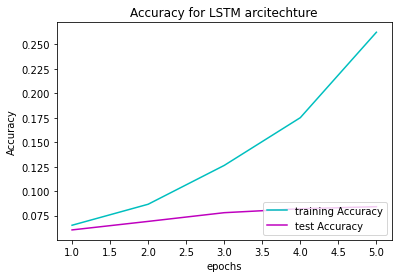

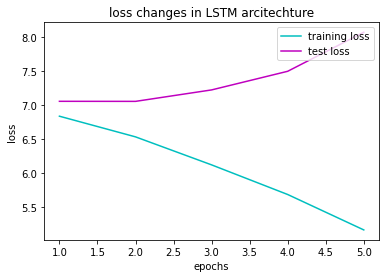

In [ ]:
# Because I can't run 10 epochs in 1 runtime of google colab GPU sharing, I devide it to two 5_epoch runtimes
# LSTM training
# This cell take a long time to run. (you can load the best trained model from the next cell)

##### FIRST RUNTIME ##############

Acc_tr_hist ,loss_tr_hist ,Acc_te_hist ,loss_te_hist = train_epochs(Data , seq2seq, loss_fn , optim_pack, epochs , best_model_dir)
MyModelAnalysis(arch_name , Acc_tr_hist , Acc_te_hist , loss_tr_hist , loss_te_hist, epochs)


mkdir: cannot create directory ‘BestModel’: File exists
/content/BestModel
Downloading...
From: https://drive.google.com/uc?id=17y96Mj67luyF7wf5leOGJbhEwO9sKnlx
To: /content/BestModel/BestLSTM_Dec.pth
100% 141M/141M [00:00<00:00, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kSYZC3rHeiH2ZW_dGdWtM-oznbcj_OP_
To: /content/BestModel/BestLSTM_Enc.pth
100% 84.6M/84.6M [00:00<00:00, 176MB/s]
/content
Epoch 1
-------------------------------
loss: 0.000651  [    0/37206]
loss: 2.402401  [ 6000/37206]
loss: 2.490851  [12000/37206]
loss: 2.620729  [18000/37206]
loss: 2.719288  [24000/37206]
loss: 2.784790  [30000/37206]
loss: 2.830361  [36000/37206]
train : 
 Accuracy: 33.9%, Avg loss per Mesra: 4.762268 

test : 
 Accuracy: 18.3%, Avg loss per Mesra: 6.315084 

Epoch 2
-------------------------------
loss: 0.000163  [    0/37206]
loss: 1.684264  [ 6000/37206]
loss: 1.810197  [12000/37206]
loss: 1.949961  [18000/37206]
loss: 2.055889  [24000/37206]
loss: 2.131158  [30000/37206]
l

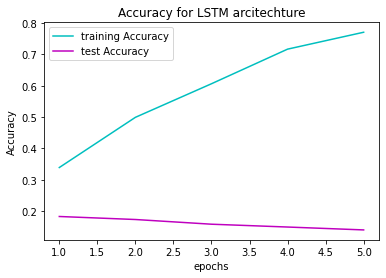

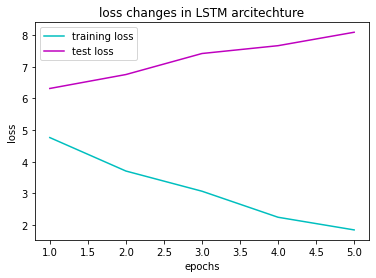

In [ ]:
##### Second RUNTIME ##############
# fine tunes the best LSTM model trained in the first 5 epochs.

!mkdir BestModel
%cd /content/BestModel/
!gdown 17y96Mj67luyF7wf5leOGJbhEwO9sKnlx # decoder
!gdown 1kSYZC3rHeiH2ZW_dGdWtM-oznbcj_OP_ # encoder
%cd /content

Best_LSTM_Enc_dir = "/content/BestModel/BestLSTM_Enc.pth"
Best_LSTM_Dec_dir = "/content/BestModel/BestLSTM_Dec.pth"

encoder1.load_state_dict(torch.load(Best_LSTM_Enc_dir))
decoder1.load_state_dict(torch.load(Best_LSTM_Dec_dir))

learning_rate = 1e-4
epochs = 5

Acc_tr_hist ,loss_tr_hist ,Acc_te_hist ,loss_te_hist = train_epochs(Data , seq2seq, loss_fn , optim_pack, epochs , best_model_dir)
MyModelAnalysis(arch_name , Acc_tr_hist , Acc_te_hist , loss_tr_hist , loss_te_hist, epochs)


In [21]:
# load the best trained model
!mkdir BestModel
%cd /content/BestModel/
!gdown 1QT4pCWqMsPMLXpEOTZc7XPf6UnlmYEFt
!gdown 1tja7eohOUoGKaqCWpK1qkK0GbILe2XG4
%cd /content

Best_LSTM_Enc_dir = "/content/BestModel/BestLSTM_Enc.pth"
Best_LSTM_Dec_dir = "/content/BestModel/BestLSTM_Dec.pth"
hidden_size = 1024
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, 'lstm').to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words, 'lstm').to(device)

encoder1.load_state_dict(torch.load(Best_LSTM_Enc_dir))
decoder1.load_state_dict(torch.load(Best_LSTM_Dec_dir))



/content/BestModel
Downloading...
From: https://drive.google.com/uc?id=1QT4pCWqMsPMLXpEOTZc7XPf6UnlmYEFt
To: /content/BestModel/BestLSTM_Enc.pth
100% 84.6M/84.6M [00:01<00:00, 43.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tja7eohOUoGKaqCWpK1qkK0GbILe2XG4
To: /content/BestModel/BestLSTM_Dec.pth
100% 141M/141M [00:03<00:00, 46.6MB/s]
/content


<All keys matched successfully>

In [ ]:
# a demo from the trained LSTM network
print('========================= LSTM demo =========================\n')
print('------------ train data prediction ------------\n')
RandomMesraPredictor(train_data, encoder1, decoder1, n=5)

print('------------ test data prediction ------------\n')
RandomMesraPredictor(test_data, encoder1, decoder1, n=5)

========================= LSTM demo =========================

------------ train data prediction ------------

first Mesra همانا بداندیش افراسیاب
second Mesra گذشتست زان سو بدریای اب
Predicted second Mesra وزین گونه فرمود تا شتاب <EOS>

first Mesra وزان پس به خواری و زخم و به بند
second Mesra به پردخت از او شهریار بلند
Predicted second Mesra به ویژه کسی کو بدی سودمند <EOS>

first Mesra زمانی نکرد او یله جای خویش
second Mesra بیفشارد بر کینه گه پای خویش
Predicted second Mesra دلیری و نیروی جنگ را پای پیش <EOS>

first Mesra چو بیدار شد رنج دیده ز خواب
second Mesra ز خوی دید جای پرستش پراب
Predicted second Mesra به نزدیک افراسیاب <EOS>

first Mesra نگون اندر امد شماساس گرد
second Mesra چو دید او ز قارن چنان دست برد
Predicted second Mesra چو دید او ز قارن چنان دست برد <EOS>

------------ test data prediction ------------

first Mesra ز چیزی که بود اندران تازه بوم
second Mesra همان جامه هایی که خیزد ز روم
Predicted second Mesra همان از پی اسب تا مرز روم <EOS>

first Mesra نباید که باشی فرا

## GRU architecture training

In [ ]:
# model characterisrics
hidden_size = 512
encoder2 = EncoderRNN(input_lang.n_words, hidden_size, 'GRU').to(device)
decoder2 = DecoderRNN(hidden_size, output_lang.n_words, 'GRU').to(device)

learning_rate = 1e-3
epochs = 5
loss_fn    = nn.CrossEntropyLoss()

optimizer1 = torch.optim.Adam(encoder2.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(decoder2.parameters(), lr=learning_rate)
optim_pack = [optimizer1,optimizer2]
seq2seq = [encoder2,decoder2]
Data    = [train_data,test_data]

best_model_dir = ["/content/drive/MyDrive/BestGRU_Enc.pth", "/content/drive/MyDrive/BestGRU_Dec.pth"]
arch_name = 'GRU'

Epoch 1
-------------------------------
loss: 0.001575  [    0/37206]
loss: 6.517219  [ 6000/37206]
loss: 6.059121  [12000/37206]
loss: 5.752512  [18000/37206]
loss: 5.586710  [24000/37206]
loss: 5.525361  [30000/37206]
loss: 5.476763  [36000/37206]
train : 
 Accuracy: 5.9%, Avg loss per Mesra: 6.941068 

test : 
 Accuracy: 5.1%, Avg loss per Mesra: 7.478075 

Epoch 2
-------------------------------
loss: 0.001066  [    0/37206]
loss: 4.803166  [ 6000/37206]
loss: 4.977103  [12000/37206]
loss: 5.018224  [18000/37206]
loss: 5.147287  [24000/37206]
loss: 5.126817  [30000/37206]
loss: 5.156772  [36000/37206]
train : 
 Accuracy: 5.6%, Avg loss per Mesra: 6.999063 

test : 
 Accuracy: 4.8%, Avg loss per Mesra: 7.612586 

Epoch 3
-------------------------------
loss: 0.000586  [    0/37206]
loss: 4.330500  [ 6000/37206]
loss: 4.528800  [12000/37206]
loss: 4.609362  [18000/37206]
loss: 4.747024  [24000/37206]
loss: 4.880591  [30000/37206]
loss: 4.904611  [36000/37206]
train : 
 Accuracy: 6.8%

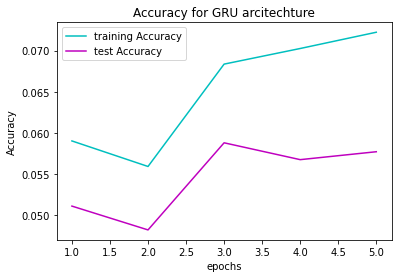

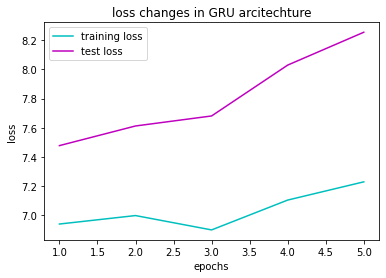

In [ ]:
# Because I can't run 10 epochs in 1 runtime of google colab GPU sharing, I devide it to two 5_epoch runtimes
# GRU training
# This cell take a long time to run. (you can load the best trained model from the next cell)

##### FIRST RUNTIME ##############

Acc_tr_hist ,loss_tr_hist ,Acc_te_hist ,loss_te_hist = train_epochs(Data , seq2seq, loss_fn , optim_pack, epochs , best_model_dir)
MyModelAnalysis(arch_name , Acc_tr_hist , Acc_te_hist , loss_tr_hist , loss_te_hist, epochs)

In [ ]:
##### Second RUNTIME ##############
# fine tunes the best GRU model trained in the first 5 epochs.

!mkdir BestModel
%cd /content/BestModel/
!gdown 1lRma1nPNaz8DkUAla3rHQf5aV3jNlo0y
!gdown 1b9UFLaRonP0SnrpDNGViZo7u-3TEuytE
%cd /content

Best_GRU_Enc_dir = "/content/BestModel/BestGRU_Enc.pth"
Best_GRU_Dec_dir = "/content/BestModel/BestGRU_Dec.pth"

encoder2.load_state_dict(torch.load(Best_GRU_Enc_dir))
decoder2.load_state_dict(torch.load(Best_GRU_Dec_dir))

learning_rate = 1e-3
epochs = 4

Acc_tr_hist ,loss_tr_hist ,Acc_te_hist ,loss_te_hist = train_epochs(Data , seq2seq, loss_fn , optim_pack, epochs , best_model_dir)
MyModelAnalysis(arch_name , Acc_tr_hist , Acc_te_hist , loss_tr_hist , loss_te_hist, epochs)

/content/BestModel
Downloading...
From: https://drive.google.com/uc?id=1lRma1nPNaz8DkUAla3rHQf5aV3jNlo0y
To: /content/BestModel/BestGRU_Dec.pth
100% 93.0M/93.0M [00:00<00:00, 182MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b9UFLaRonP0SnrpDNGViZo7u-3TEuytE
To: /content/BestModel/BestGRU_Enc.pth
100% 38.1M/38.1M [00:00<00:00, 264MB/s]
/content
Epoch 1
-------------------------------
loss: 0.000675  [    0/37206]
loss: 3.383524  [ 6000/37206]
loss: 3.589123  [12000/37206]
loss: 3.798190  [18000/37206]
loss: 3.958959  [24000/37206]
loss: 4.073998  [30000/37206]
loss: 4.164051  [36000/37206]
train : 
 Accuracy: 7.6%, Avg loss per Mesra: 7.538898 

test : 
 Accuracy: 5.8%, Avg loss per Mesra: 8.781810 

Epoch 2
-------------------------------
loss: 0.000765  [    0/37206]
loss: 3.141351  [ 6000/37206]
loss: 3.405299  [12000/37206]
loss: 3.584039  [18000/37206]
loss: 3.736389  [24000/37206]
loss: 3.837929  [30000/37206]
loss: 3.935007  [36000/37206]
train : 
 Accuracy: 7.7%, Avg

In [22]:
# load the best trained GRU model

%cd /content/BestModel/
!gdown 1lRma1nPNaz8DkUAla3rHQf5aV3jNlo0y   
!gdown 1b9UFLaRonP0SnrpDNGViZo7u-3TEuytE
%cd /content

Best_GRU_Enc_dir = "/content/BestModel/BestGRU_Enc.pth"
Best_GRU_Dec_dir = "/content/BestModel/BestGRU_Dec.pth"

hidden_size = 512
encoder2 = EncoderRNN(input_lang.n_words, hidden_size, 'gru').to(device)
decoder2 = DecoderRNN(hidden_size, output_lang.n_words, 'gru').to(device)

encoder2.load_state_dict(torch.load(Best_GRU_Enc_dir))
decoder2.load_state_dict(torch.load(Best_GRU_Dec_dir))

/content/BestModel
Downloading...
From: https://drive.google.com/uc?id=1lRma1nPNaz8DkUAla3rHQf5aV3jNlo0y
To: /content/BestModel/BestGRU_Dec.pth
100% 93.0M/93.0M [00:03<00:00, 27.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b9UFLaRonP0SnrpDNGViZo7u-3TEuytE
To: /content/BestModel/BestGRU_Enc.pth
100% 38.1M/38.1M [00:01<00:00, 30.1MB/s]
/content


<All keys matched successfully>

In [23]:
# a demo from the trained GRU network
print('========================= GRU demo =========================\n')
print('------------ train data prediction ------------\n')
RandomMesraPredictor(train_data, encoder2, decoder2, n=5)

print('------------ test data prediction ------------\n')
RandomMesraPredictor(test_data, encoder2, decoder2, n=5)

========================= GRU demo =========================

------------ train data prediction ------------

first Mesra همه دشت پر کشته و خسته بود
second Mesra بخون بزرگان زمین شسته بود
Predicted second Mesra بران سو که پور دستان بود <EOS>

first Mesra به کدبانو اندرز کرد و به مرد
second Mesra جهانی پر از دادگو را سپرد
Predicted second Mesra ز گفتار او گشت شاه جهان <EOS>

first Mesra اگر ساو و باژم فرستد نکوست
second Mesra کسی را ندرد بدین جنگ پوست
Predicted second Mesra که بر چرخ گردنده روز یاد <EOS>

first Mesra به بالا به کردار سرو سهی
second Mesra به دید را خورشید با فرهی
Predicted second Mesra ز دینار وز گوهر شاهوار <EOS>

first Mesra نه کس دید از ما نه هرگز شنید
second Mesra که دام و دد و مرغ بر ره پرید
Predicted second Mesra که بر زین دشت کس پدید امد پدید <EOS>

------------ test data prediction ------------

first Mesra میان سپاه اندر امد چو گرگ
second Mesra پراگنده گشت ان سپاه بزرگ
Predicted second Mesra ز سوگند و ان لشکر خویش دار <EOS>

first Mesra دگر لشکری کز خراسان بدند